# Timeseries of ESA soil moisture accumulation co-located with Colorado Landslide events

## Author: Jacquelyn Witte

In [110]:
import os
from glob import glob

import earthpy as et
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import pandas as pd
import re
import seaborn as sns
import xarray as xr

import warnings
warnings.filterwarnings('ignore')

# Prettier plotting with seaborn
sns.set(font_scale=1.3, style="whitegrid")

#### Function to co-locate a landslide event with soil moisture

In [61]:
def colocate_to_landslide(sm_files, glc_df, periods=7):
    """
    Returns a dataframe of soil moisture values colocated to a landslide event.
    
    Based on the Global Landslide Catalog as input.
    Define the number of day to retrieve a variable value leading up
        to a landslide event. Uses nearest neighbor method
        
    Parameters 
    ----------
    sm_files: String list of filenames
    
    glc_df: pandas.core.frame.DataFrame
        The GLC dataframe
            
    period: int
        Number of periods to generate. Default is 7 days.

    Returns
    -------
    pandas.core.frame.DataFrame 
    """

    sm_ts_list = []
    for i, date in enumerate(glc_df.index):
        #print(i, date)
        # date going back X days from the Landslide event
        # formated to match with the soil moisture file name
        glc_date = pd.date_range(date, periods=periods,
                                 freq='-1D').strftime('%Y%m%d')

        # loop over the X days and create list of DataArrays
        soil_list = []
        for dd in glc_date:
            # find the file
            file = [x for x in sm_files if re.findall(dd, x)]
            # read the file
            soil_xr = xr.open_dataset(file[0]).squeeze()
            # append to list
            soil_list.append(soil_xr)

        # now I have X files in a list
        # convert list to an xarray
        soil_xr = xr.concat(soil_list, dim="time")

        # Subset by time and space for soil moisture parameter
        soil_subset_xr = soil_xr['sm'].sel(indexers={
            'time': pd.date_range(date, periods=periods, freq='-1D'),
            'lon': glc_df.longitude[i],
            'lat': glc_df.latitude[i]},
            method="nearest")

        # append to the main list
        sm_ts_list.append(soil_subset_xr)
        sm_ts_list[i]['landslideID'] = glc_co.event_id[i]

    # Convert the big list to a DataFrame
    sm_ts_xr = xr.concat(sm_ts_list,
                          dim='landslideID',
                          fill_value=np.nan,
                          join='override')

    # Convert to a DataFrame
    sm_ts_df = sm_ts_xr.to_dataframe()
    # replace missing values with NaN
    sm_ts_df.sm[sm_ts_df['sm'] < 0.0] = np.nan

    return sm_ts_df

#### Function to calculate soil moisture statistics 

In [ ]:
def colocate_to_landslide(sm_files, glc_df, periods=30):
    """
    Returns a dataframe of soil moisture values colocated to a landslide event.
    
    Based on the Global Landslide Catalog as input.
    Define the number of day to retrieve a variable value leading up
        to a landslide event. Uses nearest neighbor method
        
    Parameters 
    ----------
    sm_files: String list of filenames
    
    glc_df: pandas.core.frame.DataFrame
        The GLC dataframe
            
    period: int
        Number of periods to generate. Default is 30 days.

    Returns
    -------
    pandas.core.frame.DataFrame 
    """

    sm_ts_list = []
    for i, date in enumerate(glc_df.index):
        #print(i, date)
        # date going back X days from the Landslide event
        # formated to match with the soil moisture file name
        glc_date = pd.date_range(date, periods=periods,
                                 freq='-1D').strftime('%Y%m%d')

        # loop over the X days and create list of DataArrays
        soil_list = []
        for dd in glc_date:
            # find the file
            file = [x for x in sm_files if re.findall(dd, x)]
            # read the file
            soil_xr = xr.open_dataset(file[0]).squeeze()
            # append to list
            soil_list.append(soil_xr)

        # now I have X files in a list
        # convert list to an xarray
        soil_xr = xr.concat(soil_list, dim="time")

        # Subset by time and space for soil moisture parameter
        soil_subset_xr = soil_xr['sm'].sel(indexers={
            'time': pd.date_range(date, periods=periods, freq='-1D'),
            'lon': glc_df.longitude[i],
            'lat': glc_df.latitude[i]},
            method="nearest")

        # append to the main list
        sm_ts_list.append(soil_subset_xr)
        sm_ts_list[i]['landslideID'] = glc_co.event_id[i]

    # Convert the big list to a DataFrame
    sm_ts_xr = xr.concat(sm_ts_list,
                          dim='landslideID',
                          fill_value=np.nan,
                          join='override')

    # Convert to a DataFrame
    sm_ts_df = sm_ts_xr.to_dataframe()
    # replace missing values with NaN
    sm_ts_df.sm[sm_ts_df['sm'] < 0.0] = np.nan

    return sm_ts_df

In [68]:
def add_count(df, days):
    """
    Adds a countdown column from N number of days to the Landslide event.
    
    Parameters
    ----------
    df: pandas.core.frame.DataFrame
    
    days: int
        Where 0 is the landslide event

    Returns
    -------
    pandas.core.frame.DataFrame plus added column
    """

    cnts = []
    accum = []
    ndays = np.arange(days)+1
    ndays = np.arange(start=-days, stop=0, step=1)
    for i in range(0, int(len(df['sm'])/days)): 
        cnts.extend(ndays)

    df['days-to-landslide'] = cnts
    return df

#### Change directory to where all the Capstone data reside

In [4]:
data_dir = os.path.join(et.io.HOME,
                        'earth-analytics',
                        'data')
os.chdir(data_dir)

#### Define the Global Landslide Catalog (GLC)

In [5]:
glc_file = os.path.join('capstone', 'landslide', 'nasa.glc.export.csv')
os.path.exists(glc_file) 

True

#### Read and subset to Colorado Landslides

In [6]:
# Read the GLC file
glc = pd.read_csv(glc_file)

glc_co = glc[(glc['country_code'] == 'US') & (
                                glc['admin_division_name'] == 'Colorado') & (
                                glc['landslide_trigger'] != 'freeze_thaw') &(
                            glc['landslide_trigger'] != 'snowfall_snowmelt')
            ]
# covert to datetime
glc_co['date'] = pd.to_datetime(glc_co['event_date'])
glc_co = glc_co.set_index('date').sort_index()
glc_co.head()

,source_name,source_link,event_id,event_date,event_time,event_title,event_description,location_description,location_accuracy,landslide_category,...,country_code,admin_division_name,admin_division_population,gazeteer_closest_point,gazeteer_distance,submitted_date,created_date,last_edited_date,longitude,latitude
date,,,,,,,,,,,,,,,,,,,,,
2007-06-01,Sky-Hi News,http://www.skyhidailynews.com/news/13393638-11...,6253,6/1/07 0:00,NaN,Granby landfill,"All in all, the county has spent over $7 milli...",Granby landfill,5km,landslide,...,US,Colorado,1864.0,Granby,5.53226,10/17/14 19:11,11/20/17 15:17,2/15/18 15:51,-105.8752,40.0929
2007-08-14,Telluride Daily Planet,http://www.telluridegateway.com/articles/2007/...,185,8/14/07 0:00,NaN,"Tellride, CO, Hwy 145",Tues afternoon 4pm,"Tellride, CO, Hwy 145",10km,mudslide,...,US,Colorado,2475.0,Meeker,10.87949,4/1/14 0:00,11/20/17 15:17,2/15/18 15:51,-107.8818,39.9425
2007-09-06,Craigdailypress.com,http://www.craigdailypress.com/news/2007/sep/0...,238,9/6/07 0:00,NaN,"River and Mt Warner Road, Steamboat Springs, CO","slide 75 feet down hill carrying trees, etc. o...","River and Mt Warner Road, Steamboat Springs, CO",1km,mudslide,...,US,Colorado,12088.0,Steamboat Springs,2.63588,4/1/14 0:00,11/20/17 15:17,2/15/18 15:51,-106.8295,40.4613
2007-09-17,KJCT news,http://kjct8.com/Global/story.asp?S=7085534,268,9/17/07 0:00,NaN,"I-70 between New Castle and Silt, Colorado",mudslides and flooding on road in early and mi...,"I-70 between New Castle and Silt, Colorado",5km,mudslide,...,US,Colorado,4518.0,New Castle,4.25758,4/1/14 0:00,11/20/17 15:17,2/15/18 15:51,-107.5798,39.5542
2008-04-13,vaildaily,http://www.vaildaily.com/article/20080428/NEWS...,499,4/13/08 0:00,NaN,U.S. Highway 6 between Kayak Crossing apartmen...,"A mudslide buried a lane, crushed a metal reta...",U.S. Highway 6 between Kayak Crossing apartmen...,5km,mudslide,...,US,Colorado,6447.0,Avon,3.03321,4/1/14 0:00,11/20/17 15:17,2/15/18 15:51,-106.4879,39.6250


In [7]:
print('The Columns names of the GLC are:')
glc_co.columns

The Columns names of the GLC are:


Index(['source_name', 'source_link', 'event_id', 'event_date', 'event_time',
       'event_title', 'event_description', 'location_description',
       'location_accuracy', 'landslide_category', 'landslide_trigger',
       'landslide_size', 'landslide_setting', 'fatality_count', 'injury_count',
       'storm_name', 'photo_link', 'notes', 'event_import_source',
       'event_import_id', 'country_name', 'country_code',
       'admin_division_name', 'admin_division_population',
       'gazeteer_closest_point', 'gazeteer_distance', 'submitted_date',
       'created_date', 'last_edited_date', 'longitude', 'latitude'],
      dtype='object')

#### Get the ESA soil moisture files co-located by Landslide event
- Final product is a dataframe

#### Create the DataFrame of co-located Landslides for the past 30 days

In [78]:
sm_files = sorted(glob(os.path.join('capstone',
                                    'esa_soil_moisture',
                                    '*.nc')))

#sm_7days_df = colocate_to_landslide(sm_files, glc_co, periods=7)
#sm_14days_df = colocate_to_landslide(sm_files, glc_co, periods=14)
sm_30days_df = colocate_to_landslide(sm_files, glc_co, periods=30)

In [79]:
sm_30days_df.head()

lon     lat         sm
landslideID time                                  
6253        2007-06-01 -105.875  40.125  42.846214
            2007-05-31 -105.875  40.125  70.264999
            2007-05-30 -105.875  40.125  58.754509
            2007-05-29 -105.875  40.125  48.185928
            2007-05-28 -105.875  40.125  40.738850

#### Add a count of X days of soil moisture measurements for each landslide event. This will help in plotting.

In [103]:
#sm_7days_df = add_count(sm_7days_df, 7)
sm_30days_df = add_count(sm_30days_df, 30)
sm_30days_df.head()

lon     lat         sm  days-to-landslide  \
landslideID time                                                        
6253        2007-06-01 -105.875  40.125  42.846214                 -7   
            2007-05-31 -105.875  40.125  70.264999                 -6   
            2007-05-30 -105.875  40.125  58.754509                 -5   
            2007-05-29 -105.875  40.125  48.185928                 -4   
            2007-05-28 -105.875  40.125  40.738850                 -3   

                        soilmoisture_accum  
landslideID time                            
6253        2007-06-01           42.846214  
            2007-05-31          113.111214  
            2007-05-30          171.865723  
            2007-05-29          220.051651  
            2007-05-28          260.790497

#### Calculated soil moisture statistics

In [104]:
sm_7day_stats = sm_7days_df.groupby('landslideID').agg({'sm': ['min', 'max', 'mean', 'median']})
sm_7day_stats.columns = sm_7day_stats.columns.map('-'.join)
sm_7day_stats

sm_30day_stats = sm_30days_df.groupby('landslideID').agg({'sm': ['min', 'max', 'mean', 'median']})
sm_30day_stats.columns = sm_30day_stats.columns.map('-'.join)
sm_30day_stats


,sm-min,sm-max,sm-mean,sm-median
landslideID,,,,
6253,33.835247,70.264999,47.219398,44.969288
185,0.689687,77.921555,30.770344,28.662251
238,6.090387,79.519180,31.640940,29.788898
268,2.061557,98.115753,34.742306,29.311626
499,NaN,NaN,NaN,NaN
...,...,...,...,...
9470,50.983776,99.358643,69.664597,69.696205
9486,19.838993,42.800716,27.619743,26.970625
9497,18.768009,96.730164,58.527409,54.157516


### Plot the distribution of the statistics

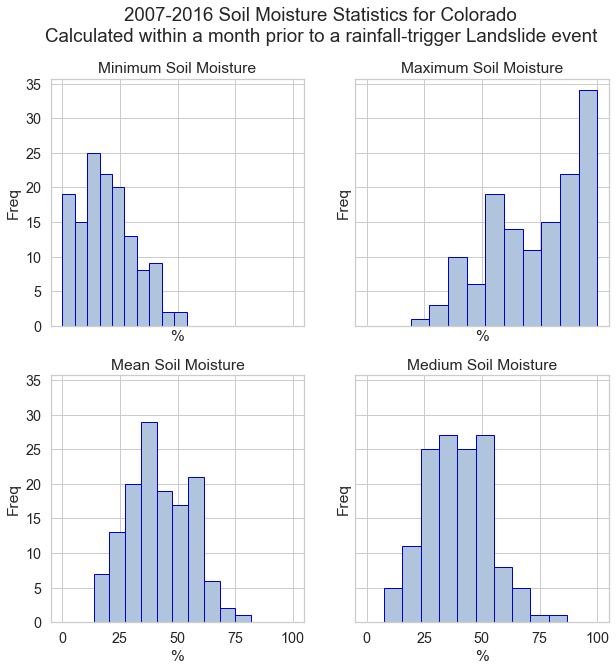

In [128]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, 
                                         figsize=(10, 10),
                                         sharex=True, sharey=True)
# Add overall figure title
tit1 = '2007-2016 Soil Moisture Statistics for Colorado'
tit2 = 'Calculated within a month prior to a rainfall-trigger Landslide event'
fig.suptitle(tit1+'\n'+tit2)


# the histogram of the data
sm_30day_stats['sm-min'].hist(ax=ax1, 
                              color='lightsteelblue', edgecolor='mediumblue')
sm_30day_stats['sm-max'].hist(ax=ax2,
                              color='lightsteelblue', edgecolor='mediumblue')
sm_30day_stats['sm-mean'].hist(ax=ax3,
                              color='lightsteelblue', edgecolor='mediumblue')
sm_30day_stats['sm-median'].hist(ax=ax4,
                              color='lightsteelblue', edgecolor='mediumblue')

ax1.set(xlabel='%', ylabel='Freq',
        title='Minimum Soil Moisture');
ax2.set(xlabel='%', ylabel='Freq',
        title='Maximum Soil Moisture');
ax3.set(xlabel='%', ylabel='Freq',
        title='Mean Soil Moisture');
ax4.set(xlabel='%', ylabel='Freq',
        title='Medium Soil Moisture');

#### Save soil moisture statistics to a csv file

In [130]:
sm_30day_stats.to_csv(os.path.join(
    'capstone', 'esa_soil_moisture', 'esa_sm_2007-2016_co_stats_30days.csv'))